vgg pretrained (not fine tuned)

In [1]:
import tensorflow as tf
from keras.layers import Conv3D, Dense, MaxPooling3D, Flatten, Dropout, BatchNormalization, LeakyReLU
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.losses import binary_crossentropy, categorical_crossentropy
from keras.applications.vgg16 import VGG16

from keras.applications.vgg16 import preprocess_input

import numpy as np

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, f1_score, recall_score, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn import metrics as mt

import os
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from matplotlib import pyplot as plt

import csv

In [2]:
pd.options.display.max_rows = 91

### ADD ALL Parameters HERE - epochs,  batchsize, lr etc. and use these variables only in the code ahead

In [3]:
# adam optimizer default learning rate = 0.001
lr = 0.0001 #learning rate
ep = 1
batch_size = 1
n_splits = 5

In [4]:
# not performing fine tuning during training
def get_model(num_classes):

    #returns compiled model for the smri pipeline
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Add classification layers
    x = base_model.output
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer=Adam(learning_rate = lr), loss='categorical_crossentropy', metrics=['accuracy'])
    print("Output shape of the model:", model.output_shape)

    return model

In [5]:
def compile_fit(model, X_train, y_train, X_val, y_val):

    hist = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=ep, batch_size = batch_size)

    return model, hist

In [6]:
def plot_history(hist, n):
    fig, ax = plt.subplots(2)
    ax[0].plot(hist.history['accuracy'], color="blue")
    ax[0].plot(hist.history['val_accuracy'], color="green")
    ax[0].set(xlabel="epochs", ylabel="Accuracy")
    ax[0].set_xlim((0,ep))
    ax[0].set_ylim((0,1))
    ax[0].legend(['training', 'testing'])
    ax[0].set_title("Accuracy Trend")

    ax[1].plot(hist.history['loss'], color="blue")
    ax[1].plot(hist.history['val_loss'], color="green")
    ax[1].set(xlabel="epochs", ylabel="Loss")
    ax[1].set_xlim((0,ep))
    ax[1].set_ylim((0,1))
    ax[1].legend(['training', 'testing'])
    ax[1].set_title("Loss Trend")

    fig.tight_layout(pad=2.0)
    plt.show()

In [7]:
def eval_model(num_classes, model, X_val, y_val, y_cols):
  # Compute loss and accuracy using model.evaluate()
  loss, acc = model.evaluate(X_val, y_val)

  y_pred = model.predict(X_val)
  print('y_pred', y_pred)
  print('y_val', y_val)

  if (num_classes == 3) :

    # Convert y_val to multiclass format
    y_val = np.argmax(y_val, axis=1)

    # Convert y_pred to multiclass format
    y_pred = np.argmax(y_pred, axis=1)

    print('y_pred', y_pred)
    print('y_val', y_val)

    # Check the type of y_pred_probs
    print("Type of y_pred using model.predict:", type(y_pred))
    print("shape of the y_pred using model.predict:", y_pred.shape)

    # Compute confusion matrix
    # y_val_argmax = np.argmax(y_val, axis=1)
    # y_pred_argmax = np.argmax(y_pred, axis=1)
    # conf_mat = confusion_matrix(y_val_argmax, y_pred_argmax)

    conf_mat = mt.confusion_matrix(y_val, y_pred)
    print("confusion matrix ", conf_mat)

    target_names = y_cols

    print("classification report", mt.classification_report(y_val, y_pred, target_names=target_names, digits = 3))

    # Compute classification report
    report = mt.classification_report(y_val, y_pred, target_names=target_names, output_dict=True)
    report_df = pd.DataFrame(report).T

    print("classification report in dataframe - match accuracy with model.evaluate ")
    print(report_df)

    # Select the first three rows
    report_df_top3 = report_df.head(3)

    # Calculate average metrics for the first three rows
    avg_precision = report_df_top3['precision'].mean()
    avg_recall = report_df_top3['recall'].mean()
    avg_f1_score = report_df_top3['f1-score'].mean()

    print(f"Average Precision (first 3 classes): {avg_precision:.3f}")
    print(f"Average Recall (first 3 classes): {avg_recall:.3f}")
    print(f"Average F1-Score (first 3 classes): {avg_f1_score:.3f}")

    metrics = {
        'acc': acc,
        'loss': loss,
        'conf_mat': conf_mat,
        'sens (recall)': avg_recall,
        'f1': avg_f1_score,
        'prec': avg_precision
    }

  elif (num_classes == 2) :

    # Convert y_val to multiclass format
    y_val = np.argmax(y_val, axis=1)

    # Convert y_pred to multiclass format
    y_pred = np.argmax(y_pred, axis=1)

    print('y_pred', y_pred)
    print('y_val', y_val)

    # Check the type of y_pred_probs
    print("Type of y_pred using model.predict:", type(y_pred))
    print("shape of the y_pred using model.predict:", y_pred.shape)

    # Compute confusion matrix
    conf_mat = confusion_matrix(y_val, y_pred)

    # Compute confusion matrix
    # y_pred = np.argmax(y_pred, axis=1)
    # conf_mat = confusion_matrix(y_val, y_pred)

    # Compute metrics from confusion matrix
    tn, fp, fn, tp = conf_mat.ravel()
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)

    metrics = {
        'acc': acc,
        'loss': loss,
        'conf_mat': conf_mat,
        'sens (recall)': recall,
        'f1': f1,
        'prec': precision,
        'tn': tn,
        'tp': tp,
        'fn': fn,
        'fp': fp
    }

  else :
    metrics = {}

  return metrics

In [8]:
# Replacing nan values to 1
def nan_to_0(data):

    df1 = data.copy()

    for idx, row in df1.iterrows():
      arr = row['fcmap']
      matrix = np.nan_to_num(arr, copy = True, nan = 0.0)
      df1.at[idx, 'fcmap'] = matrix

    print(df1)

    return df1

In [9]:
def computeMinMax(X):
  min_matrix = X.min(axis = 0)
  max_matrix = X.max(axis = 0)
  return (min_matrix, max_matrix)

#### **MAKING CHANGES HERE** ..

In [10]:
def normalize_instance(X, minn, maxx):
  normalised_X = np.zeros(shape=(X.shape[0], X.shape[1]))

  for idx, x in np.ndenumerate(X):
    if minn[idx] == maxx[idx]:
      normalised_X[idx] = x
    else:
      normalised_X[idx] = (x - minn[idx])/(maxx[idx] - minn[idx])
    return normalised_X

In [11]:
def normalize(X_train, X_val):
    # Assuming X_train is your DataFrame with matrices in a single column
    matrices = X_train  # Get the values from the 'matrices' column
    # Convert the matrices to a 2D NumPy array
    X_train_2d = np.stack(matrices)

    # Assuming X_train is your DataFrame with matrices in a single column
    matrices = X_val  # Get the values from the 'matrices' column
    # Convert the matrices to a 2D NumPy array
    X_val_2d = np.stack(matrices)

    min_matrix, max_matrix = computeMinMax(X_train_2d)

    print("shape of min matrix", min_matrix.shape)
    print("shape of max matrix", max_matrix.shape)

    normalized_instances = []
    for instance in X_train_2d:
        normalized_instance = normalize_instance(instance, min_matrix, max_matrix)
        normalized_instances.append(normalized_instance)

    # Convert the list of normalized instances to a NumPy array
    X_normalized_trained_2d = np.array(normalized_instances)

    normalized_instances = []
    for instance in X_val_2d:
        normalized_instance = normalize_instance(instance, min_matrix, max_matrix)
        # print(normalized_instance)
        normalized_instances.append(normalized_instance)

    # Convert the list of normalized instances to a NumPy array
    X_normalized_val_2d = np.array(normalized_instances)

    return (X_normalized_trained_2d, X_normalized_val_2d)

In [12]:
# # Padding Matrices
# def padding_data(data):
#     def pad_matrix(row):
#         arr = row['fcmap']
#         pad_top = (224 - arr.shape[0]) // 2
#         pad_bottom = 224 - arr.shape[0] - pad_top
#         pad_left = (224 - arr.shape[1]) // 2
#         pad_right = 224 - arr.shape[1] - pad_left
#         padded_matrix = np.pad(arr, ((pad_top, pad_bottom), (pad_left, pad_right)), mode='constant')
#         return padded_matrix

#     df_pad = data.copy()

#     df_pad['fcmap'] = df_pad.apply(lambda row: pad_matrix(row), axis=1)

#     return df_pad

def padding_data(X, target_shape=(224, 224)):
    """
    Pad each matrix in X_train to the target shape.

    Args:
        X_train (numpy.ndarray): Input array containing matrices.
        target_shape (tuple): Target shape for padding.

    Returns:
        numpy.ndarray: Padded matrices.
    """
    padded_matrices = []

    for matrix in X:
        pad_top = (target_shape[0] - matrix.shape[0]) // 2
        pad_bottom = target_shape[0] - matrix.shape[0] - pad_top
        pad_left = (target_shape[1] - matrix.shape[1]) // 2
        pad_right = target_shape[1] - matrix.shape[1] - pad_left

        padded_matrix = np.pad(matrix, ((pad_top, pad_bottom), (pad_left, pad_right)), mode='constant')
        padded_matrices.append(padded_matrix)

    return np.array(padded_matrices)

In [13]:
def increase_channels(X):
    # preparing data for vgg pre-trained
    X = np.stack(X).reshape(-1, 224, 224)
    print("stacking all matrices together", X.shape)
    X = np.expand_dims(X, axis=-1)
    print("adding channel dimension", X.shape)
    X = np.repeat(X, 3, axis=-1)
    print("increasing channels for vgg", X.shape)

    return X

In [14]:
def make_dataset(choice):
    # Load dataframe from the pickle file
    data = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/RRC_FcMaps/FCmaps_data.pkl')

    if choice == 'A':
        # Filter rows where 'adhd' or 'autism' is 1 (keep only ADHD or autism subjects)
        data = data[(data['adhd'] == 1) | (data['autism'] == 1)]
        y_cols = ['adhd', 'autism']  # Specify the columns for y
    elif choice == 'B':
        # Filter rows where 'autism' or 'healthy' is 1 (keep only autism or healthy subjects)
        data = data[(data['autism'] == 1) | (data['healthy'] == 1)]
        y_cols = ['autism', 'healthy']  # Specify the columns for y
    elif choice == 'C':
        # Filter rows where 'adhd' or 'healthy' is 1 (keep only ADHD or healthy subjects)
        data = data[(data['adhd'] == 1) | (data['healthy'] == 1)]
        y_cols = ['adhd', 'healthy']  # Specify the columns for y
    elif choice == 'D':
        # Keep all rows
        y_cols = ['adhd', 'autism', 'healthy']  # Specify the columns for y
    else:
        print("Invalid choice. Please enter 'A', 'B', 'C', or 'D'.")
        return pd.DataFrame(), []

    print(data)

    df1 = nan_to_0(data)

    print(y_cols)
    return df1, y_cols

In [15]:
def driver(choice):

    # choice = input("Enter your choice (A, B, C, or D): ").upper()

    choice = choice.upper()

    df, y_cols = make_dataset(choice)
    #print(d.head)

    X = df['fcmap'].values
    # print(X.shape)
    # print(X)
    print("type of matrices", type(X))
    y = df[y_cols].values
    #y = to_categorical(y, num_classes=3)
    # print(y.shape)
    # print(y)
    print("type of label columns", type(y))

    # Get the number of classes
    num_classes = y.shape[1]
    print("No. of classes", num_classes)

    if (num_classes == 2) :
      result_df = pd.DataFrame(columns = ['fold','acc','loss','conf_mat', 'sens (recall)','f1','prec', 'tn', 'tp', 'fn', 'fp'])
    elif (num_classes == 3) :
      result_df = pd.DataFrame(columns = ['fold','acc','loss','conf_mat', 'sens (recall)','f1','prec'])
    else :
      result_df = {}

    # input_shape_2 = X[0].shape
    # # input_shape = input_shape + (2,)
    # print(input_shape_2) // in case, sent as argument to get_model()

    # n_splits = n_splits # Number of folds

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    tf.keras.backend.clear_session()
    for i, (train_index, val_index) in enumerate(kf.split(X, y)):

        print("FOLD : ", i+1)

        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        X_normal_train, X_normal_val = normalize(X_train, X_val)

        X_train_pad = padding_data(X_normal_train)
        X_val_pad = padding_data(X_normal_val)

        X_train_vgg = increase_channels(X_train_pad)
        X_val_vgg = increase_channels(X_val_pad)

        # print(X_val_vgg[0].shape)

        compiled_m = get_model(num_classes)

        #compiled_m.summary()
        trained_m, history = compile_fit(compiled_m, X_train_vgg, np.array(y_train), X_val_vgg, np.array(y_val))
        plot_history(history, i+1)

        scores = eval_model(num_classes, trained_m, X_val_vgg, y_val, y_cols)
        scores['fold']=i+1
        print("Scores", scores)
        scores = pd.DataFrame([scores])
        result_df = pd.concat([result_df,scores], ignore_index=True)
        tf.keras.backend.clear_session()

    return result_df

        subject                                              fcmap  adhd  \
0      subject1  [[nan, 0.5238301930931133, -0.2282216203110824...     0   
1      subject2  [[nan, 0.4748539075236425, 0.04488964356167748...     0   
2      subject3  [[nan, -0.3223992385318596, -0.017720272215859...     0   
3      subject4  [[nan, 0.29769854683773916, -0.024657165451793...     0   
4      subject5  [[nan, 0.5938212810274702, 0.01331333354518493...     0   
..          ...                                                ...   ...   
160  subject161  [[nan, 0.7733577328202523, -0.2179115860832922...     0   
161  subject162  [[nan, 0.7322498529648797, -0.3588026757164758...     0   
162  subject163  [[nan, 0.6245252761351467, -0.2657320122905972...     0   
163  subject164  [[nan, 0.3310417663685341, -0.0407639816131658...     0   
164  subject165  [[nan, 1.1199278166916429, -0.2410820711755044...     0   

     autism  healthy  
0         1        0  
1         1        0  
2         1       

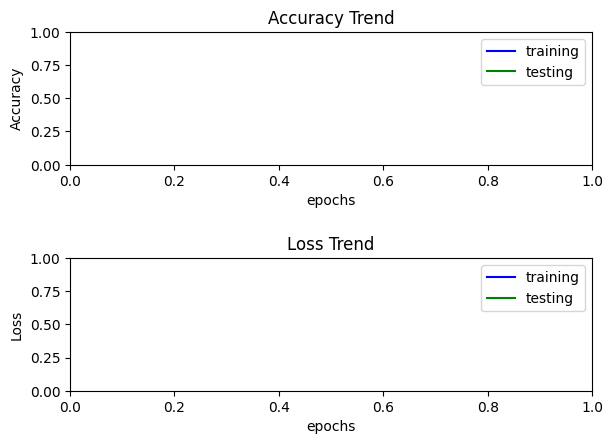

2/2 [==============================] - 0s 99ms/step
y_pred [[0.34191188 0.46215954 0.19592859]
 [0.34191188 0.46215954 0.19592859]
 [0.34191188 0.46215954 0.19592859]
 [0.34191188 0.46215954 0.19592859]
 [0.34191188 0.46215954 0.19592859]
 [0.34191188 0.46215954 0.19592859]
 [0.34191188 0.46215954 0.19592859]
 [0.34191188 0.46215954 0.19592859]
 [0.34191188 0.46215954 0.19592859]
 [0.34191188 0.46215954 0.19592859]
 [0.34191188 0.46215954 0.19592859]
 [0.34191188 0.46215954 0.19592859]
 [0.34191188 0.46215954 0.19592859]
 [0.34191188 0.46215954 0.19592859]
 [0.34191188 0.46215954 0.19592859]
 [0.34191188 0.46215954 0.19592859]
 [0.34191188 0.46215954 0.19592859]
 [0.34191188 0.46215954 0.19592859]
 [0.34191188 0.46215954 0.19592859]
 [0.34191188 0.46215954 0.19592859]
 [0.34191188 0.46215954 0.19592859]
 [0.34191188 0.46215954 0.19592859]
 [0.34191188 0.46215954 0.19592859]
 [0.34191188 0.46215954 0.19592859]
 [0.34191188 0.46215954 0.19592859]
 [0.34191188 0.46215954 0.19592859]
 [0.3

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

increasing channels for vgg (132, 224, 224, 3)
stacking all matrices together (33, 224, 224)
adding channel dimension (33, 224, 224, 1)
increasing channels for vgg (33, 224, 224, 3)
Output shape of the model: (None, 3)
132/132 [==============================] - 3s 17ms/step - loss: 1.7269 - accuracy: 0.2879 - val_loss: 1.4642 - val_accuracy: 0.3636


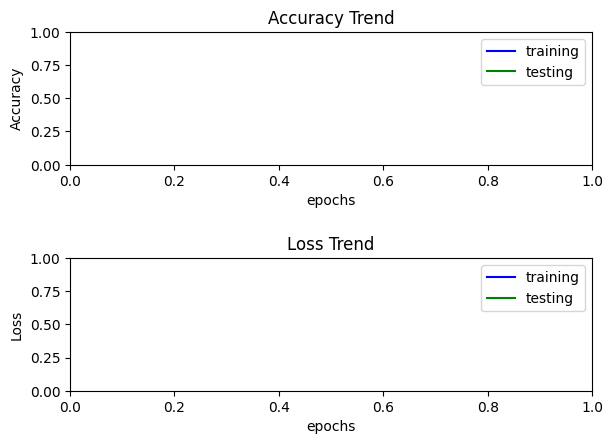

2/2 [==============================] - 1s 100ms/step
y_pred [[0.54507965 0.07754823 0.37737218]
 [0.54507965 0.07754823 0.37737218]
 [0.54507965 0.07754823 0.37737218]
 [0.54507965 0.07754823 0.37737218]
 [0.54507965 0.07754823 0.37737218]
 [0.54507965 0.07754823 0.37737218]
 [0.54507965 0.07754823 0.37737218]
 [0.54507965 0.07754823 0.37737218]
 [0.54507965 0.07754823 0.37737218]
 [0.54507965 0.07754823 0.37737218]
 [0.54507965 0.07754823 0.37737218]
 [0.54507965 0.07754823 0.37737218]
 [0.54507965 0.07754823 0.37737218]
 [0.54507965 0.07754823 0.37737218]
 [0.54507965 0.07754823 0.37737218]
 [0.54507965 0.07754823 0.37737218]
 [0.54507965 0.07754823 0.37737218]
 [0.54507965 0.07754823 0.37737218]
 [0.54507965 0.07754823 0.37737218]
 [0.54507965 0.07754823 0.37737218]
 [0.54507965 0.07754823 0.37737218]
 [0.54507965 0.07754823 0.37737218]
 [0.54507965 0.07754823 0.37737218]
 [0.54507965 0.07754823 0.37737218]
 [0.54507965 0.07754823 0.37737218]
 [0.54507965 0.07754823 0.37737218]
 [0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

stacking all matrices together (132, 224, 224)
adding channel dimension (132, 224, 224, 1)
increasing channels for vgg (132, 224, 224, 3)
stacking all matrices together (33, 224, 224)
adding channel dimension (33, 224, 224, 1)
increasing channels for vgg (33, 224, 224, 3)
Output shape of the model: (None, 3)
132/132 [==============================] - 4s 17ms/step - loss: 1.7019 - accuracy: 0.2803 - val_loss: 1.2091 - val_accuracy: 0.3030


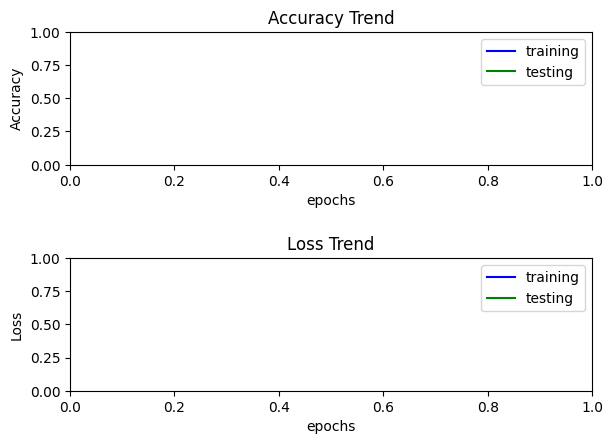

2/2 [==============================] - 0s 104ms/step
y_pred [[0.4269072  0.3877843  0.18530844]
 [0.4269072  0.3877843  0.18530844]
 [0.4269072  0.3877843  0.18530844]
 [0.4269072  0.3877843  0.18530844]
 [0.4269072  0.3877843  0.18530844]
 [0.4269072  0.3877843  0.18530844]
 [0.4269072  0.3877843  0.18530844]
 [0.4269072  0.3877843  0.18530844]
 [0.4269072  0.3877843  0.18530844]
 [0.4269072  0.3877843  0.18530844]
 [0.4269072  0.3877843  0.18530844]
 [0.4269072  0.3877843  0.18530844]
 [0.4269072  0.3877843  0.18530844]
 [0.4269072  0.3877843  0.18530844]
 [0.4269072  0.3877843  0.18530844]
 [0.4269072  0.3877843  0.18530844]
 [0.4269072  0.3877843  0.18530844]
 [0.4269072  0.3877843  0.18530844]
 [0.4269072  0.3877843  0.18530844]
 [0.4269072  0.3877843  0.18530844]
 [0.4269072  0.3877843  0.18530844]
 [0.4269072  0.3877843  0.18530844]
 [0.4269072  0.3877843  0.18530844]
 [0.4269072  0.3877843  0.18530844]
 [0.4269072  0.3877843  0.18530844]
 [0.4269072  0.3877843  0.18530844]
 [0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

stacking all matrices together (33, 224, 224)
adding channel dimension (33, 224, 224, 1)
increasing channels for vgg (33, 224, 224, 3)
Output shape of the model: (None, 3)
132/132 [==============================] - 3s 17ms/step - loss: 1.7638 - accuracy: 0.3561 - val_loss: 1.3370 - val_accuracy: 0.3636


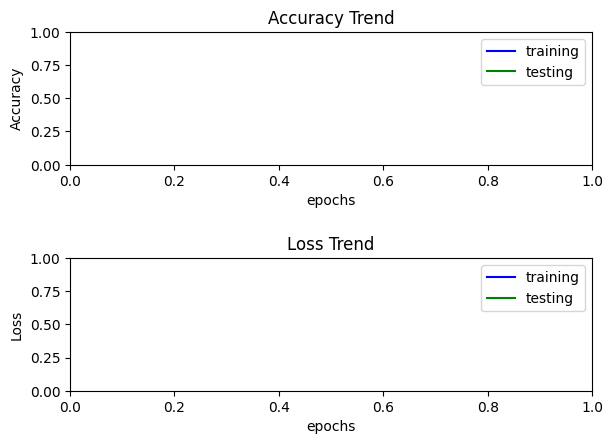

2/2 [==============================] - 0s 102ms/step
y_pred [[0.29655847 0.59819007 0.10525151]
 [0.29655847 0.59819007 0.10525151]
 [0.29655847 0.59819007 0.10525151]
 [0.29655847 0.59819007 0.10525151]
 [0.29655847 0.59819007 0.10525151]
 [0.29655847 0.59819007 0.10525151]
 [0.29655847 0.59819007 0.10525151]
 [0.29655847 0.59819007 0.10525151]
 [0.29655847 0.59819007 0.10525151]
 [0.29655847 0.59819007 0.10525151]
 [0.29655847 0.59819007 0.10525151]
 [0.29655847 0.59819007 0.10525151]
 [0.29655847 0.59819007 0.10525151]
 [0.29655847 0.59819007 0.10525151]
 [0.29655847 0.59819007 0.10525151]
 [0.29655847 0.59819007 0.10525151]
 [0.29655847 0.59819007 0.10525151]
 [0.29655847 0.59819007 0.10525151]
 [0.29655847 0.59819007 0.10525151]
 [0.29655847 0.59819007 0.10525151]
 [0.29655847 0.59819007 0.10525151]
 [0.29655847 0.59819007 0.10525151]
 [0.29655847 0.59819007 0.10525151]
 [0.29655847 0.59819007 0.10525151]
 [0.29655847 0.59819007 0.10525151]
 [0.29655847 0.59819007 0.10525151]
 [0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

increasing channels for vgg (132, 224, 224, 3)
stacking all matrices together (33, 224, 224)
adding channel dimension (33, 224, 224, 1)
increasing channels for vgg (33, 224, 224, 3)
Output shape of the model: (None, 3)
132/132 [==============================] - 4s 17ms/step - loss: 1.7709 - accuracy: 0.2576 - val_loss: 1.3570 - val_accuracy: 0.3333


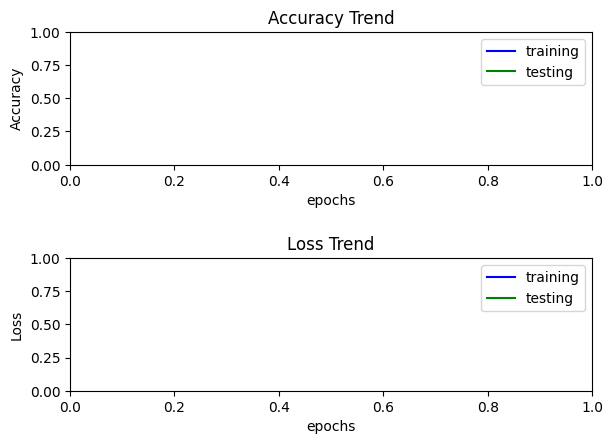

2/2 [==============================] - 0s 17ms/step - loss: 1.3570 - accuracy: 0.3333


2/2 [==============================] - 0s 98ms/step
y_pred [[0.11106949 0.44348404 0.4454465 ]
 [0.11106949 0.44348404 0.4454465 ]
 [0.11106949 0.44348404 0.4454465 ]
 [0.11106949 0.44348404 0.4454465 ]
 [0.11106949 0.44348404 0.4454465 ]
 [0.11106949 0.44348404 0.4454465 ]
 [0.11106949 0.44348404 0.4454465 ]
 [0.11106949 0.44348404 0.4454465 ]
 [0.11106949 0.44348404 0.4454465 ]
 [0.11106949 0.44348404 0.4454465 ]
 [0.11106949 0.44348404 0.4454465 ]
 [0.11106949 0.44348404 0.4454465 ]
 [0.11106949 0.44348404 0.4454465 ]
 [0.11106949 0.44348404 0.4454465 ]
 [0.11106949 0.44348404 0.4454465 ]
 [0.11106949 0.44348404 0.4454465 ]
 [0.11106949 0.44348404 0.4454465 ]
 [0.11106949 0.44348404 0.4454465 ]
 [0.11106949 0.44348404 0.4454465 ]
 [0.11106949 0.44348404 0.4454465 ]
 [0.11106949 0.44348404 0.4454465 ]
 [0.11106949 0.44348404 0.4454465 ]
 [0.11106949 0.44348404 0.4454465 ]
 [0.11106949 0.44348404 0.4454465 ]
 [0.11106949 0.44348404 0.4454465 ]
 [0.11106949 0.44348404 0.4454465 ]
 [0.1

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

In [18]:
# Define a list of choices
# choices = ['A', 'B', 'C', 'D']
choices = ['D']

# Create an empty dictionary to store the result dataframes
result_dfs = {}

# Loop through each choice
for choice in choices:
    # Call the driver() function with the current choice
    result_df = driver(choice)

    # Store the result dataframe in the dictionary with the choice as the key
    result_dfs[choice] = result_df

In [ ]:
print(result_dfs['A'])

  fold       acc      loss          conf_mat  sens (recall)        f1  \
0    1  0.500000  0.724987  [[6, 0], [6, 0]]            0.0  0.000000   
1    2  0.416667  1.254118  [[0, 7], [0, 5]]            1.0  0.588235   
2    3  0.583333  0.691159  [[0, 5], [0, 7]]            1.0  0.736842   
3    4  0.333333  1.255678  [[0, 8], [0, 4]]            1.0  0.500000   
4    5  0.636364  0.673779  [[0, 4], [0, 7]]            1.0  0.777778   

       prec tn tp fn fp  
0  0.000000  6  0  6  0  
1  0.416667  0  5  0  7  
2  0.583333  0  7  0  5  
3  0.333333  0  4  0  8  
4  0.636364  0  7  0  4  


In [ ]:
print(result_dfs['B'])

  fold       acc      loss          conf_mat  sens (recall)   f1      prec tn  \
0    1  0.333333  1.508365  [[4, 0], [8, 0]]            0.0  0.0  0.000000  4   
1    2  0.500000  0.707297  [[6, 0], [6, 0]]            0.0  0.0  0.000000  6   
2    3  0.666667  0.639697  [[8, 0], [4, 0]]            0.0  0.0  0.000000  8   
3    4  0.666667  0.839063  [[0, 4], [0, 8]]            1.0  0.8  0.666667  0   
4    5  0.583333  0.682799  [[7, 0], [5, 0]]            0.0  0.0  0.000000  7   

  tp fn fp  
0  0  8  0  
1  0  6  0  
2  0  4  0  
3  8  0  4  
4  0  5  0  


In [ ]:
print(result_dfs['C'])

  fold       acc      loss          conf_mat  sens (recall)        f1  \
0    1  0.615385  0.718446  [[0, 5], [0, 8]]            1.0  0.761905   
1    2  0.583333  0.822346  [[7, 0], [5, 0]]            0.0  0.000000   
2    3  0.500000  0.716370  [[0, 6], [0, 6]]            1.0  0.666667   
3    4  0.416667  0.719656  [[5, 0], [7, 0]]            0.0  0.000000   
4    5  0.583333  0.775630  [[7, 0], [5, 0]]            0.0  0.000000   

       prec tn tp fn fp  
0  0.615385  0  8  0  5  
1  0.000000  7  0  5  0  
2  0.500000  0  6  0  6  
3  0.000000  5  0  7  0  
4  0.000000  7  0  5  0  


In [ ]:
print(result_dfs['D'])

  fold       acc      loss                            conf_mat  sens (recall)  \
0    1  0.444444  1.066631   [[0, 6, 0], [0, 8, 0], [0, 4, 0]]       0.333333   
1    2  0.222222  1.148250   [[0, 6, 0], [0, 4, 0], [0, 8, 0]]       0.333333   
2    3  0.555556  1.027540  [[0, 4, 0], [0, 10, 0], [0, 4, 0]]       0.333333   
3    4  0.388889  1.090923  [[0, 0, 10], [0, 0, 1], [0, 0, 7]]       0.333333   
4    5  0.222222  1.500596   [[4, 0, 0], [6, 0, 0], [8, 0, 0]]       0.333333   

         f1      prec  
0  0.205128  0.148148  
1  0.121212  0.074074  
2  0.238095  0.185185  
3  0.186667  0.129630  
4  0.121212  0.074074  


# Binary Classification


In [17]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def make_dataset(choice):
    # Load dataframe from the pickle file
    data = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/RRC_FcMaps/FCmaps_data(132x132).pkl')

    if choice == 'A':
        # Filter rows where 'adhd' or 'autism' is 1 (keep only ADHD or autism subjects)
        data = data[(data['adhd'] == 1) | (data['autism'] == 1)]
        y_cols = ['adhd', 'autism']  # Specify the columns for y
    elif choice == 'B':
        # Filter rows where 'autism' or 'healthy' is 1 (keep only autism or healthy subjects)
        data = data[(data['autism'] == 1) | (data['healthy'] == 1)]
        y_cols = ['autism', 'healthy']  # Specify the columns for y
    elif choice == 'C':
        # Filter rows where 'adhd' or 'healthy' is 1 (keep only ADHD or healthy subjects)
        data = data[(data['adhd'] == 1) | (data['healthy'] == 1)]
        y_cols = ['adhd', 'healthy']  # Specify the columns for y
    elif choice == 'D':
        # Keep all rows
        y_cols = ['adhd', 'autism', 'healthy']  # Specify the columns for y
    else:
        print("Invalid choice. Please enter 'A', 'B', 'C', or 'D'.")
        return pd.DataFrame(), []

    print(data)
    return data, y_cols

In [ ]:
def driver():

    choice = input("Enter your choice (A, B, C, or D): ").upper()

    df, y_cols = make_dataset(choice)
    #print(d.head)

    X = df['fcmap'].values
    # print(X.shape)
    # print(X)
    print(type(X))
    y = df[y_cols].values
    #y = to_categorical(y, num_classes=3)
    # print(y.shape)
    # print(y)
    print(type(y))

    return df, y

In [ ]:
data, cols = driver()

Enter your choice (A, B, C, or D): b
      subject                                              fcmap  adhd  \
0    subject2  [[nan, 1.0036407419797173, 0.18701701249003255...     0   
1    subject3  [[nan, 0.11609198595144368, 0.1180324429589779...     0   
2    subject4  [[nan, 0.9455449941229485, 0.08125902553011471...     0   
3    subject5  [[nan, 0.4748647287729013, 0.04488949863183865...     0   
4    subject6  [[nan, 0.29773898486020245, -0.024693109742462...     0   
5    subject7  [[nan, 0.5045539860398821, 0.10547073160173422...     0   
6    subject8  [[nan, 0.14904166555433965, -0.101659951673909...     0   
7    subject9  [[nan, 0.46905585525737276, 0.2049692700427807...     0   
8   subject10  [[nan, 0.4229180323975888, -0.0739174446574339...     0   
9   subject11  [[nan, 0.3304728252919811, -0.0177715723544977...     0   
10  subject12  [[nan, 0.4612037095005987, -0.0124061486931631...     0   
11  subject13  [[nan, 0.28911114342223876, 0.1835245557297164...     0   
1

In [ ]:
data

,subject,fcmap,adhd,autism,healthy
0,subject2,"[[nan, 1.0036407419797173, 0.18701701249003255...",0,1,0
1,subject3,"[[nan, 0.11609198595144368, 0.1180324429589779...",0,1,0
2,subject4,"[[nan, 0.9455449941229485, 0.08125902553011471...",0,1,0
3,subject5,"[[nan, 0.4748647287729013, 0.04488949863183865...",0,1,0
4,subject6,"[[nan, 0.29773898486020245, -0.024693109742462...",0,1,0
5,subject7,"[[nan, 0.5045539860398821, 0.10547073160173422...",0,1,0
6,subject8,"[[nan, 0.14904166555433965, -0.101659951673909...",0,1,0
7,subject9,"[[nan, 0.46905585525737276, 0.2049692700427807...",0,1,0
8,subject10,"[[nan, 0.4229180323975888, -0.0739174446574339...",0,1,0
9,subject11,"[[nan, 0.3304728252919811, -0.0177715723544977...",0,1,0


In [ ]:
data.shape

(60, 5)

In [ ]:
cols

array([[1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1]], dtype=int32)

In [ ]:
cols.shape

(60, 2)

In [ ]:
d1 = data.iloc[1,1]

In [ ]:
d1

array([[        nan,  0.11609199,  0.11803244, ...,  0.00081802,
         0.05087084, -0.21485529],
       [ 0.11609199,         nan,  0.01597281, ...,  0.07131454,
        -0.00891681, -0.07999328],
       [ 0.11803244,  0.01597281,         nan, ..., -0.27890578,
        -0.30029972,  0.09006511],
       ...,
       [ 0.00081802,  0.07131454, -0.27890578, ...,         nan,
         0.26801991, -0.07263152],
       [ 0.05087084, -0.00891681, -0.30029972, ...,  0.26801991,
                nan,  0.00112975],
       [-0.21485529, -0.07999328,  0.09006511, ..., -0.07263152,
         0.00112975,         nan]])

In [ ]:
d1.shape

(132, 132)

# 3 class confusion matrix

In [ ]:
from sklearn import metrics
import pandas as pd

In [ ]:
d = "dogs"
c = "cats"
f = "fish"

In [ ]:
y_true = [c,c,c,c,c,c, f,f,f,f,f,f,f,f,f,f, d,d,d,d,d,d,d,d,d]

y_pred = [c,c,c,c,d,f, c,c,c,c,c,c,d,d,f,f, c,c,c,d,d,d,d,d,d]

In [ ]:
print(metrics.confusion_matrix(y_true, y_pred))

[[4 1 1]
 [3 6 0]
 [6 2 2]]


In [ ]:
print(metrics.classification_report(y_true, y_pred, digits = 3))

              precision    recall  f1-score   support

        cats      0.308     0.667     0.421         6
        dogs      0.667     0.667     0.667         9
        fish      0.667     0.200     0.308        10

    accuracy                          0.480        25
   macro avg      0.547     0.511     0.465        25
weighted avg      0.581     0.480     0.464        25



In [ ]:
report = metrics.classification_report(y_true, y_pred, output_dict=True)

In [ ]:
report_df = pd.DataFrame(report).T

In [ ]:
report_df

,precision,recall,f1-score,support
cats,0.307692,0.666667,0.421053,6.00
dogs,0.666667,0.666667,0.666667,9.00
fish,0.666667,0.200000,0.307692,10.00
accuracy,0.480000,0.480000,0.480000,0.48
macro avg,0.547009,0.511111,0.465137,25.00
weighted avg,0.580513,0.480000,0.464130,25.00


In [ ]:
# Select the first three rows
report_df_top3 = report_df.head(3)

# Calculate average metrics for the first three rows
avg_precision = report_df_top3['precision'].mean()
avg_recall = report_df_top3['recall'].mean()
avg_f1_score = report_df_top3['f1-score'].mean()

print(f"Average Precision (first 3 classes): {avg_precision:.3f}")
print(f"Average Recall (first 3 classes): {avg_recall:.3f}")
print(f"Average F1-Score (first 3 classes): {avg_f1_score:.3f}")

Average Precision (first 3 classes): 0.547
Average Recall (first 3 classes): 0.511
Average F1-Score (first 3 classes): 0.465
